# Exercise sheet 6
---
**Machine Learning for Physics and Astronomy**

Semester 2, Period 5, 2021/2022

dr. Christoph Weniger, Andrea Visibile, Christiaan van Asperen, Dion Noordhuis, Kamile Lukosiute, Mathis Gerdes, Noemi Anau Montel, Silvia Cassanelli

To be handed in until **25/05/2022** evening. Total points 25 pt.

---



### Remember, if you get the error "No CUDA GPUs are available," go to Runtime > Change runtime type > select GPU.

## Chapter 10: Simulation based inference (25 pt total + 7 bonus pt)

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

In [3]:
torch.cuda.is_available()

True

### 1. Measuring Rings (7 pt)

In the last homework session we classified numbers on the MNIST dataset, but this is not representative of the types of tasks that we use neural neutworks for in physics. So we now move on to a different task: measuring the radius of rings produced by a simulator. We define a function that serves as our "simulator," `image_model` which produces images with one or more rings, where the radius, width, and number of rings are simulation parameters. 

This model is a toy model for producing simulated images of graviationally lensed systems.  The radius would then correspond to the "Einstein radius" of the [gravitational lensing system](https://en.wikipedia.org/wiki/Einstein_ring) and tell us something about the mass of the lensing galaxy. The width would correspond to the size of the lensed source galaxy.  Normally, you would not get multiple rings in one image, but in our toy model we add this possibility to test just how difficult we can make the problem while still learning the parameters. 

As an example, a real strong lensing image looks like this:

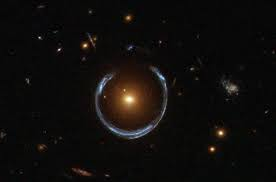

So now we define our "simulator."

In [4]:
def image_model(radius = 0.5, sigma = 0.3, width = 0.15, n = 1):
    x = np.linspace(-2, 2, 32)
    X, Y = np.meshgrid(x, x)
    
    # Random position of the ring
    imgs = []
    for i in range(n):
      x0, y0 = np.random.uniform(-1, 1, 2)

      R = ((X-x0)**2 + (Y-y0)**2)**0.5
      img = np.exp(-(R-radius)**2/width**2/2)
      img = img

      imgs.append(img)
    
    # Standard variance and zero mean
    img = sum(imgs)

    # Remove mean and variance
    img -= img.mean()
    img /= img.std()

    # Add image noise
    img += np.random.randn(*img.shape)*sigma


    return img.reshape(1, 32, 32).astype(np.float32)  # Default CUDA tensors are float32

Next, we next generate our training and test data. In this case, 50000 examples.

In [5]:
ring_data = []
for i in range(50000):
  r = np.random.rand(1).astype(np.float32)
  img = image_model(n = 3, radius = r)
  ring_data.append((img, r))

class RingDataset(torch.utils.data.Dataset):
  def __init__(self, ring_data):
    self.ring_data = ring_data

  def __getitem__(self, idx):
    return self.ring_data[idx]

  def __len__(self):
    return len(self.ring_data)

ring_dataset_train = RingDataset(ring_data[:45000])
ring_dataset_test = RingDataset(ring_data[45000:])

We then instantiate the loaders.

In [6]:
batch_size_train = 64  # by default we use a minibatch size of 64 for training.
# You can leave it like that during the subsequent exercises.

batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(ring_dataset_train, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(ring_dataset_test, batch_size=batch_size_test, shuffle=True)

In [7]:
examples = list(test_loader)
example_data, example_targets = examples[0]

And plot test examples.

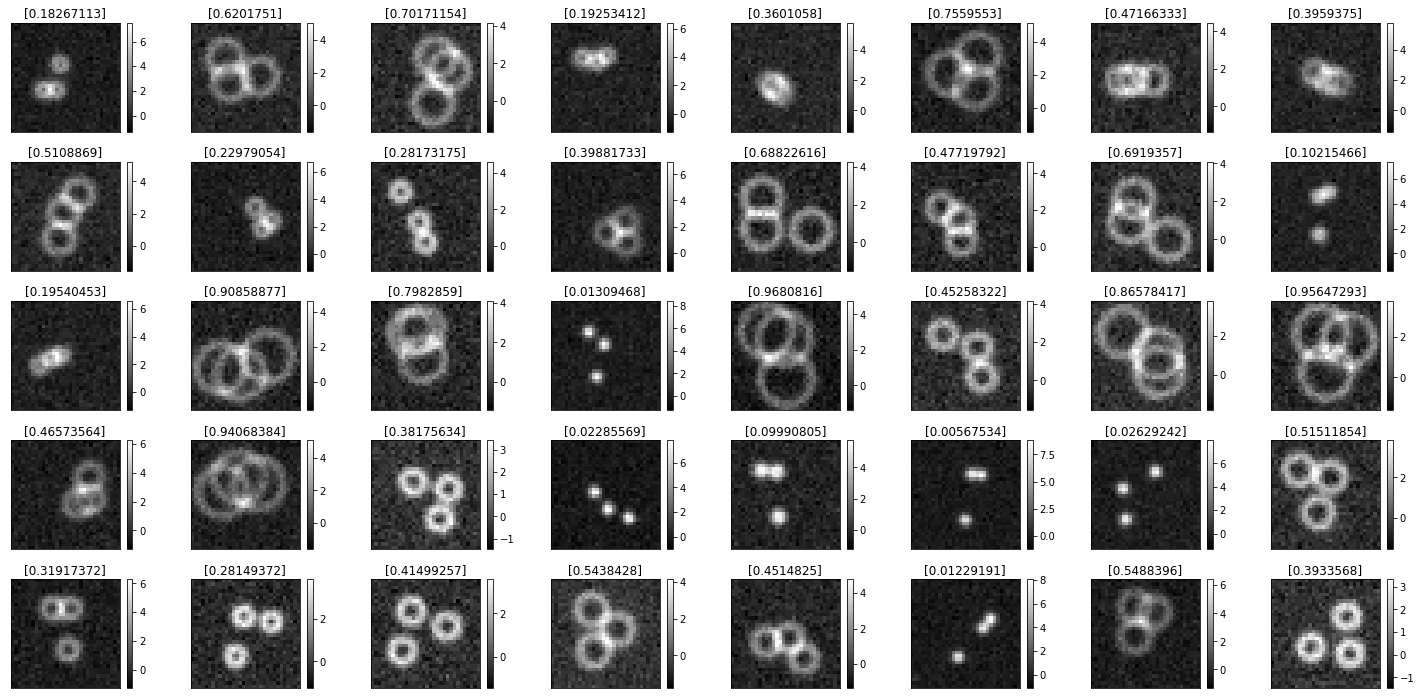

In [8]:
fig = plt.figure(figsize=(20, 10))
for i in range(40):
  plt.subplot(5,8,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("{}".format(example_targets[i].numpy()))
  plt.xticks([])
  plt.yticks([])
  plt.colorbar()

We first start with a regression-based implementation, where we will train a neural network to predict the radius as a single number directly.

1. Regression model. Adapt the CNN used on the MNIST dataset in the last homework to predict a single real-valued number that represents the radius. (2pt)

In [9]:

class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1=nn.Conv2d(1,10,kernel_size=5,padding=(2,2))
    self.conv2=nn.Conv2d(10,20,kernel_size=5)
    self.conv2_drop=nn.Dropout2d()
    self.linear1=nn.Linear(720,50)
    self.linear2=nn.Linear(50,1)
  
  def forward(self,x):
   x=F.relu(F.max_pool2d(self.conv1(x),2))
   x=F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
   x=x.view(-1,720)
   x=F.relu(self.linear1(x))
   x=F.dropout(x,training=self.training)
   x=self.linear2(x)
   return x

    

2. Before, we were doing classification and so we used the appropriate cross-entropy loss. Now, we must replace the loss with mean square error (MSE) for regression. Define the training loop below with this new loss function. (1pt)

In [10]:

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    data = data.to(DEVICE)
    target = target.to(DEVICE)
    output = network(data)
    loss = F.mse_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

3. Train the network on GPU. If everything works, you should see that the loss decreases. (Refer to previous exercises if you need guidance.) (2pt)

Hint: If your network doesn't train, try using a smaller learning rate (e.g. 0.001).

In [11]:
learning_rate = 0.001

network = Net().to(DEVICE)  # We move the network to the GPU
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [12]:
n_epochs=3
log_interval = 10
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
for epoch in range(1, n_epochs + 1):
    train(epoch)

Train Epoch: 1 [0/45000 (0%)]	Loss: 0.458371
Train Epoch: 1 [640/45000 (1%)]	Loss: 0.128236
Train Epoch: 1 [1280/45000 (3%)]	Loss: 0.067092
Train Epoch: 1 [1920/45000 (4%)]	Loss: 0.086221
Train Epoch: 1 [2560/45000 (6%)]	Loss: 0.052640
Train Epoch: 1 [3200/45000 (7%)]	Loss: 0.049062
Train Epoch: 1 [3840/45000 (9%)]	Loss: 0.030883
Train Epoch: 1 [4480/45000 (10%)]	Loss: 0.038123
Train Epoch: 1 [5120/45000 (11%)]	Loss: 0.050975
Train Epoch: 1 [5760/45000 (13%)]	Loss: 0.051599
Train Epoch: 1 [6400/45000 (14%)]	Loss: 0.043469
Train Epoch: 1 [7040/45000 (16%)]	Loss: 0.048541
Train Epoch: 1 [7680/45000 (17%)]	Loss: 0.024846
Train Epoch: 1 [8320/45000 (18%)]	Loss: 0.040340
Train Epoch: 1 [8960/45000 (20%)]	Loss: 0.033558
Train Epoch: 1 [9600/45000 (21%)]	Loss: 0.035965
Train Epoch: 1 [10240/45000 (23%)]	Loss: 0.033082
Train Epoch: 1 [10880/45000 (24%)]	Loss: 0.031729
Train Epoch: 1 [11520/45000 (26%)]	Loss: 0.034604
Train Epoch: 1 [12160/45000 (27%)]	Loss: 0.037172
Train Epoch: 1 [12800/45000

As it can been seen from above the loss starts from 0.14 and it drops to 0.0095 for learning rate 0.0001

4. Illustrate the reconstruction quality by running 1000 test images through the network and recording the outputs.  Show correct (x-axis) vs reconstructed (y-axis) radii in a scatter plot (`plt.scatter`). How well does your network perform? (1pt)

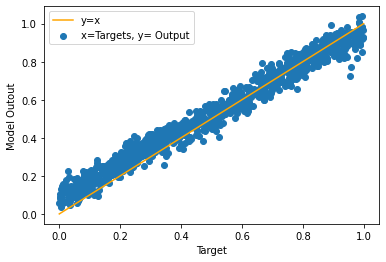

In [13]:
for data, target in test_loader:
      data = data.to(DEVICE)
      target = target.to(DEVICE)

network.eval()
output=network(data)

target= target.cpu().detach().numpy()
output=output.cpu().detach().numpy()

x=np.linspace(0,1,100)
plt.figure()
plt.scatter(target,output,label='x=Targets, y= Output')
plt.plot(x,x,label='y=x',color='orange')
plt.xlabel('Target')
plt.ylabel('Model Outout')
plt.legend()
plt.show()







To see if our model performs well it should give the line y=x because the output should be  equal to the targets. In the plot above I have plotted the y=x line for reference and as we can see most of our points are near to that line. So we can say that our model performs well.


5. Imagine your are provided with a single image, and you have to use your network to estimate the radius of the rings and quote your best estimate together with error bars. Write 2-3 qualitative sentences about how you could obtain this error bar from the plot that you generated in the previous point. (1pt)

We would use our model with input the one image and then we would plot the point againist the y=x line. Then I would calculate the y-x differnce then using the survival function of the standard normal and use the difference as input to get a corresponding p-value. And then use the percent point function to turn that in to error estimates. So I could then give the error estimates for differnt p-values.


### 2. Simulation-based inference of posteriors (9 pt + 3 bonus pt)

In the previous exercise, we predicted a single value for the radius, but this did not tell us anything about the probability of the predicted value. In this exercise, we will use the neural likelihood-free based inference method (focusing on neural ratio estimation) discussed in class to obtain proper Bayesian posteriors for the radius, instead of just a point estimator.

Let's start by defining a neural network that takes as input both an image $x$ as well as a label (in our case radius) $z$.  The output will be the probability that $x$ and $z$ are jointly drawn, $x, z \sim p(x, z)$, rather than marginally, $x, z \sim p(x)p(z)$.

In [14]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(501, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x, z):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 500)
        x = torch.cat((x, z), axis = 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

1. What does the `torch.cat` function do in this context? Relate it back to the math dicussed in class.  (1 pt)

The `torch.cat` concatenates the vectors x and z. Which is something like horizontal stack because  `axis=1`. In other words it appends x and z. The math of this can be found in the slide 30 of the lecture slides for chapter 11. Basically the concatenated vector of x,a is the input for our multilayer perceptron where x is the summary statistics and z the parameter of interest. 


Now we define the optimizer, and instantiate the network.

In [15]:
learning_rate = 0.001
DEVICE = 'cuda'
network = Net().to(DEVICE)  # We move the network to the GPU
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

By default, we will use `n_epochs = 3` throughout.  Leave it like that.

In [16]:
n_epochs = 3  # 3 epochs by default. 

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

This is the main training loop is now given as follows.

In [17]:
log_interval = 10

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    data = data.to(DEVICE)
    target = target.to(DEVICE)

    output_joined = network(data[1:], target[1:])
    output_marginal = network(data[1:], torch.randn_like(target[1:]))

    loss = -torch.log(output_joined) - torch.log(1-output_marginal)
    loss = loss.sum()

    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

2. Explain the role of the two different `output` variables, and how those enter the binary cross-entropy loss function. Write down the mathematical definition of the loss function that we implement (in terms of an integral). (1 pt)

The problem that we are trying to solve is essentially a binary classification problem where it gives us the probability  the pair x,z comes from the joined rather than the marginal distribution. The way the joined distribution  is implemented it returns p(x|z) and the marginal it returns p(x),p(z). Both of those are included in the loss function which is:

$-\int p(x,z)ln\frac{p(s(x),z)}{p(s(x),z)+p(s(x))p(z)}+p(s(x))p(z)ln\frac{p(s(x))p(z)}{p(s(x),z)+p(s(x))p(z)}\,dx\,dz$

where s(x) is the summary statitics generated from the network.


In [18]:
for epoch in range(1, n_epochs + 1):
  train(epoch)

Train Epoch: 1 [0/45000 (0%)]	Loss: 87.276657
Train Epoch: 1 [640/45000 (1%)]	Loss: 86.342209
Train Epoch: 1 [1280/45000 (3%)]	Loss: 86.158234
Train Epoch: 1 [1920/45000 (4%)]	Loss: 85.444122
Train Epoch: 1 [2560/45000 (6%)]	Loss: 84.524216
Train Epoch: 1 [3200/45000 (7%)]	Loss: 85.005424
Train Epoch: 1 [3840/45000 (9%)]	Loss: 81.689026
Train Epoch: 1 [4480/45000 (10%)]	Loss: 83.737778
Train Epoch: 1 [5120/45000 (11%)]	Loss: 80.600082
Train Epoch: 1 [5760/45000 (13%)]	Loss: 84.587997
Train Epoch: 1 [6400/45000 (14%)]	Loss: 84.944176
Train Epoch: 1 [7040/45000 (16%)]	Loss: 77.710678
Train Epoch: 1 [7680/45000 (17%)]	Loss: 77.855965
Train Epoch: 1 [8320/45000 (18%)]	Loss: 78.979416
Train Epoch: 1 [8960/45000 (20%)]	Loss: 79.500221
Train Epoch: 1 [9600/45000 (21%)]	Loss: 78.106880
Train Epoch: 1 [10240/45000 (23%)]	Loss: 77.769836
Train Epoch: 1 [10880/45000 (24%)]	Loss: 83.164055
Train Epoch: 1 [11520/45000 (26%)]	Loss: 76.964363
Train Epoch: 1 [12160/45000 (27%)]	Loss: 83.326675
Train E

3. Write some code to plot, for a given image, the posterior of the radius. To this end, the network should be evaluated for the same $x$ and for a continuous range of $z$'s (i.e. radii).  Plot the posterior for 10 different images, together with the true values as a vertical line (`plt.axvline`). Hint: check how the data were generated to remind yourself of the allowed radii in our synthetic dataset. Make sure to correctly normalize the posterior to one (neural ratio estimation provides posteriors that are only approximately normalized to one). (3 pt)

In [19]:
z_prior=torch.linspace(0,1,1000)

def posterior():
  out=[]
  for i in z_prior:
    network.eval()
    i=i.to(DEVICE)
    output_joined=network(data,i.reshape(1,1))
    output_marginal=network(data,i.reshape(1,1))
    rat=output_joined/1000*output_marginal
    out.append(rat.cpu().detach().numpy())

  out=np.array(out).reshape(1000,1)
  return (out)


For radius tensor([[0.0979]], device='cuda:0')


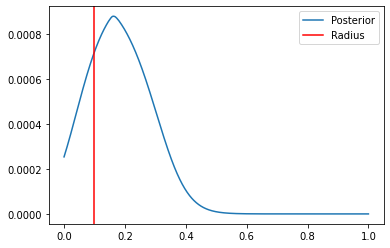

For radius tensor([[0.6254]], device='cuda:0')


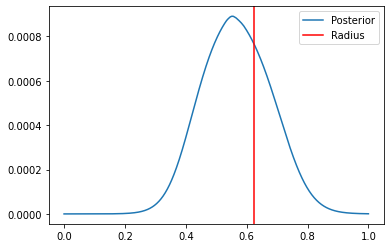

For radius tensor([[0.4830]], device='cuda:0')


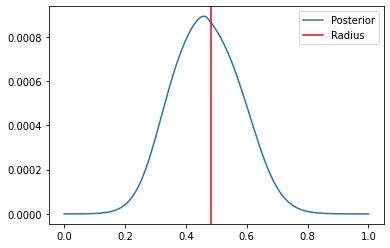

For radius tensor([[0.3290]], device='cuda:0')


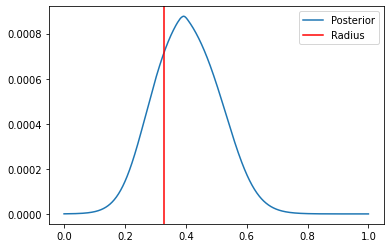

For radius tensor([[0.5171]], device='cuda:0')


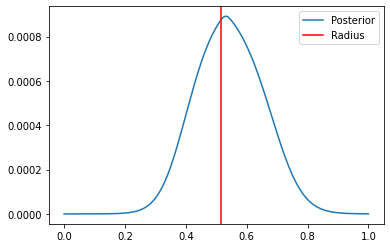

For radius tensor([[0.6829]], device='cuda:0')


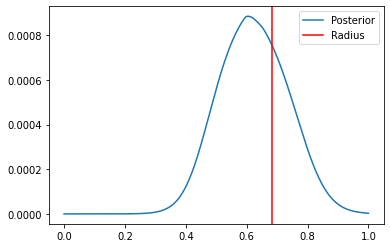

For radius tensor([[0.7937]], device='cuda:0')


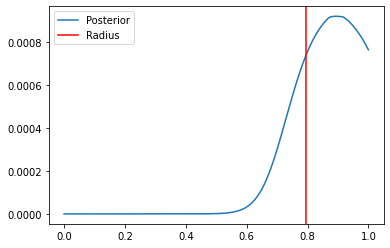

For radius tensor([[0.6590]], device='cuda:0')


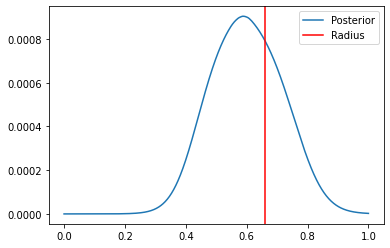

For radius tensor([[0.8160]], device='cuda:0')


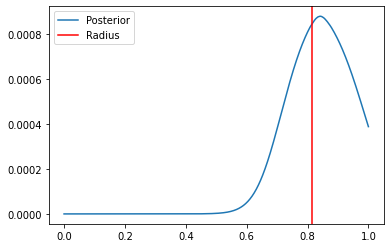

For radius tensor([[0.8094]], device='cuda:0')


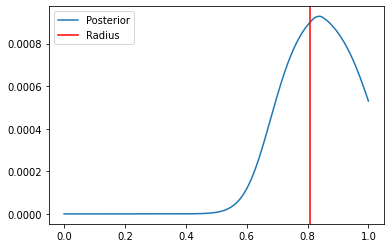

In [20]:

for i in range(10):
  test_loader = torch.utils.data.DataLoader(ring_dataset_test, batch_size=1, shuffle=True)
  for data, target in test_loader:
    data = data.to(DEVICE)
    target = target.to(DEVICE)
  post=posterior()
  print("For radius",target)
  fig=plt.figure()
  plt.plot(z_prior.cpu().detach().numpy(),post,label='Posterior')
  plt.axvline(target.cpu().detach().numpy(),color='red',label='Radius')
  plt.legend()
  plt.show()


4. For each image in the test dataset, derive a posterior and then the boundaries of the 68% credible interval (highest posterior density interval). Next, since our test dataset contains 1000 examples, calculate the fraction of the test examples where the true value lies within the 68% containment interval of the posterior predicted by the neural network. Report this value. Lastly, visualize this by plotting, for each example in the test dataset, a black vertical line representing the containment interval on a plot where the x_axis indicates the true values of the radius and the y-axis represens the NN-predicted values. (4 pts) 

Hint: your plot should look something like this in the end:

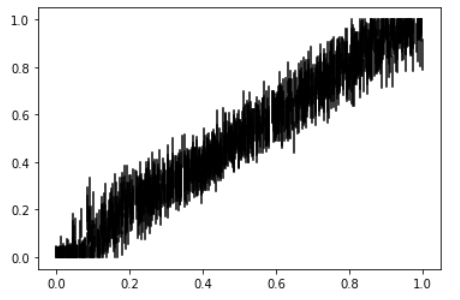

In [21]:
posteriors=[]
targets=[]
number_of_iterations=100

for i in range(number_of_iterations):
  test_loader = torch.utils.data.DataLoader(ring_dataset_test, batch_size=1, shuffle=True)
  for data, target in test_loader:
    data = data.to(DEVICE)
    target = target.to(DEVICE)
  post=posterior()
  posteriors.append(post)
  print("Calculating posteriors step",i)
  targets.append(target.cpu().detach().numpy())



Calculating posteriors step 0
Calculating posteriors step 1
Calculating posteriors step 2
Calculating posteriors step 3
Calculating posteriors step 4
Calculating posteriors step 5
Calculating posteriors step 6
Calculating posteriors step 7
Calculating posteriors step 8
Calculating posteriors step 9
Calculating posteriors step 10
Calculating posteriors step 11
Calculating posteriors step 12
Calculating posteriors step 13
Calculating posteriors step 14
Calculating posteriors step 15
Calculating posteriors step 16
Calculating posteriors step 17
Calculating posteriors step 18
Calculating posteriors step 19
Calculating posteriors step 20
Calculating posteriors step 21
Calculating posteriors step 22
Calculating posteriors step 23
Calculating posteriors step 24
Calculating posteriors step 25
Calculating posteriors step 26
Calculating posteriors step 27
Calculating posteriors step 28
Calculating posteriors step 29
Calculating posteriors step 30
Calculating posteriors step 31
Calculating poster

In [22]:
fraction=0
boundaries=[]
radii=[]#The radius that our model predicts
z=z_prior.cpu().detach().numpy()

for i in range(number_of_iterations):
  #Here I find for what radius is the most probable
  prob=posteriors[i]
  max_prob=np.amax(prob)
  z=np.reshape(z,(len(z),1))
  j,k=np.where(max_prob==prob)
  max_z=z[j,k]
  
  #The 68% credible interval is the max +- a standard diviation
  low_band=max_z-np.std(posteriors[i])
  max_band=max_z+np.std(posteriors[i])

#I am keeping the boundaries for the error bar
  boundaries.append([low_band,max_band])
  radii.append(max_z)

  if(targets[i]<=max_band and targets[i]>=low_band):
    fraction=fraction+1

print("The fraction is:",fraction/number_of_iterations)
  



The fraction is: 0


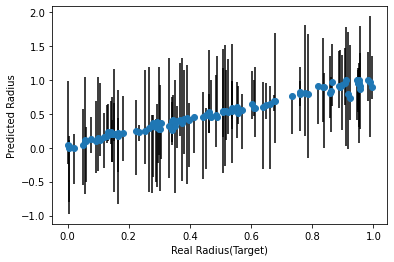

In [23]:
bound=np.reshape(np.array(boundaries),(2,len(boundaries)))
plt.figure()
plt.errorbar(targets,radii,yerr=bound,ecolor='black',marker='o',fmt='.')
plt.xlabel('Real Radius(Target)')
plt.ylabel('Predicted Radius')
plt.show()

I kept the number of iterations 100 which means 100 images because for 1000 images it was about half an hour to run but it can run for 1000 images as well in the plot above we can see the credible interval of each image with black lines and the point of each measurement as blue datapoint. We can see that the plot looks like the one above but with less lines.

5. (BONUS 3pt) Repeat part of the previous exercise for 95% and 99% credible intervals and estimate the fraction of training data examples where the true value is contained in the credible interval (no visualization like in the previous exercise required).  Discuss whether your posterior estimation is conservative or overconfident.


In [24]:
## your code here

YOUR ANSWER HERE


### 3. Properties of the KL divergence (9 pt + 4 bonus pt)

During the lecture you have learnt about the Kullback-Leibler divergence, a statistical distance that measures how one target probability distribution $P$ is different from a reference probability distribution $Q$. In this exercise we will explore some of its properties.

Let's assume your target distribution $P(x)$ is a mixture model of two Gaussians. An implementation is given as follow. Leave the means and variances parameters as given.

In [25]:
def p(x, mu1=-3, mu2=5, sigma1=1, sigma2=2, prob=0.5):
  gauss1 = torch.distributions.Normal(mu1,sigma1)
  gauss2 = torch.distributions.Normal(mu2,sigma2)
  return prob * gauss1.log_prob(x).exp() + (1-prob) * gauss2.log_prob(x).exp()

1. Write your $Q(x)$ distribution as a simple gaussian. The Gaussian PDF function will take as input parameters where it is evaluated `x`, the mean `mu` and the variance `sigma`. `mu` and `sigma` will be the parameters we are going to optimize. (1 pt)


In [26]:
def q(x, mu, sigma):
  gauss = torch.distributions.Normal(mu,sigma)
  return gauss.log_prob(x).exp()
  

2. Create an array of points $x$ where to evaluate the two distributions $P(x)$ and $Q(x)$ in order to be able to visualize them on a plot (i.e. must include the mean values defined above for the gaussian mixture distribution). Choose initial values of `mu` and `sigma` for $Q(x)$. Plot $P(x)$ and $Q(x)$. (1 pt)

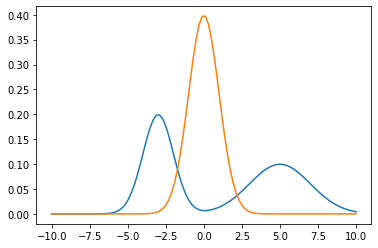

In [27]:
x=np.linspace(-10,10,100)
x_tensor=torch.from_numpy(x)

plt.figure()
plt.plot(x,p(x_tensor))
plt.plot(x,q(x_tensor,0,1))

3. Implement your forward and reverse KL divergence. To perform the integration use `torch.trapezoid`, carefully read its [documentation](https://pytorch.org/docs/stable/generated/torch.trapezoid.html#torch.trapezoid). Compute the forward and reverse KL divergence between the two distributions. Discuss why the KL divergence is not a distance metric. (3 pt)

Hint: if you get Nan or Inf value it's due to numerical instability. Try adding a *small* (e.g. $10^{-20}$) constant to the probability densities where necessary to avoid it.

In [28]:
#First we implement the forward Kl divergence

for_int=p(x_tensor)*np.log(p(x_tensor)/q(x_tensor,0,1))
for_KLD=torch.trapezoid(for_int)

#Now we implement the backward KL divergence
back_int=q(x_tensor,0,1)*np.log(q(x_tensor,0,1)/p(x_tensor))
back_KLD=torch.trapezoid(back_int)

print("The forward KL divergence is:",for_KLD)
print("The backward KL divergence is: ",back_KLD)

The forward KL divergence is: tensor(39.9028, dtype=torch.float64)
The backward KL divergence is:  tensor(13.8564, dtype=torch.float64)


As it is said in the lecture notes the KL divergence is way to to quantify the distance between the true and the approximate distribution. Basically the KL divergence measures how much different the two distributions are. To be more exact the KL divergence is a statistical distance and it is not a metric distance because it does not satisfy the triangle inequality. It is asymetrical because as we can see from above the forward and baclward KL divergences are different.

4. In order to optimize the mean and variance of our reference distribution $Q$, evaluate on a grid of `mu` and `sigma` values the forward and the reverse KL divergence. Visualize the grids for the forward and the reverse KL divergence using `plt.imshow` and **carefully** read its documentation to plot it correctly (100 points in the grid will be enough). Discuss your results. What does this maps show you? When is it better to use forward KL divergence? When is it better to use reverse KL divergence? Why? (4 pt)

In [29]:
n_grid = 100

mu_values=torch.linspace(-5,5,n_grid)
sigma_values=torch.linspace(0.1,1,n_grid)

forward_KL=[]
backward_KL=[]
for i in mu_values:
  for j in sigma_values:
    for_int=p(x_tensor)*np.log(p(x_tensor)/(q(x_tensor,i,j)+10**(-20)))
    for_KLD=torch.trapezoid(for_int)
    forward_KL.append(for_KLD.cpu().detach().numpy())

    back_int=q(x_tensor,i,j)*np.log(q(x_tensor,i,j)/(p(x_tensor)+10**(-20)))
    back_KLD=torch.trapezoid(back_int)
    backward_KL.append(back_KLD.cpu().detach().numpy())


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


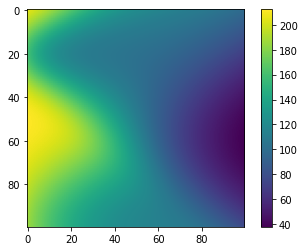

In [30]:
#For the forward divergence
forward_KL=np.reshape(np.array(forward_KL),(100,100))
plt.imshow(forward_KL)
plt.colorbar()

This image as well as the next one shows the value of the KL divergence for different sigma and mu of the q distribution. Each point is connected to the sigma and mu arrays that are imlemented above. For example the pixel (60,40) refers to the 60th element of the sigma values ant 40th element of the mu_values array. We can see from the image above that the forward KL divergence works better in the area 100,60 which translates for grid values of sigma around 1 and mu around 0.1 (The 100th element of sigma_values and the 60th element of mu_values.) The forward KL diverge is mass covering so it is natural to get the lower KL divergence values for mu around the middle of the two peaks.

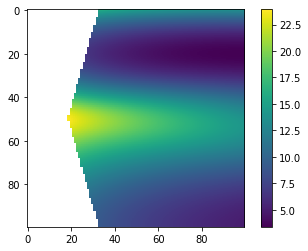

In [31]:
#For the backward divergence
backward_KL=np.reshape(np.array(backward_KL),(100,100))
plt.imshow(backward_KL)
plt.colorbar()

From the image above we can see that the backward KL divergence works better around the are (80,20)  which translates to mu -2,5(20th element) and sigma 0.8. This is logical because the backward KL divergence is mode seeking and the highest peak of p is around -3. Also we can see in both case we get lower KL values for large sigma(x axis) which is normal because the larger the sigma the wider the q is going to be so it is going to cover better the distribution p.

5. (BONUS 2pt) In the previous homework you've familiarized with pytorch automatic differentiation. This is helpful in order to optimize `mu` and `sigma` in a continous way, instead of on a grid, by minimizing the KL divergence. 

  The optimizing loop is given as follow. We are first going to do **forward KL divergence**. Complete the function below by correctly implementing the forward KL divergence loss. Plot again your target distribution $P(x)$ and $Q(x)$ with the optimized parameters `mu` and `sigma`. Discuss your results in light of the previous considerations on the grid map.

In [32]:
def optimize_loss():
    
    mu = torch.tensor([0.], requires_grad=True)
    sigma = torch.tensor([1.], requires_grad=True)    

    optimizer = torch.optim.Adam([mu, sigma])

    loss_val = []
    epochs = 10000

    for i in range(epochs):
        # qx = q(x, mu=mu, sigma=sigma) 
        
        loss = 0 # complete here with forward KL divergence

        # This lines are commented out in order not to break the notebook 
        # if the loss line is not complete

        # optimizer.zero_grad()
        # loss.backward()    
        # optimizer.step()
        # loss_val.append(loss.detach().numpy())
        
        if i%(epochs//100)==0:
            print('Epoch:',i, 'Loss:',loss.data.numpy(), 'mu:', mu.data.numpy()[0],'sigma:', sigma.data.numpy()[0])

    print('Epoch:',i, 'Loss:',loss.data.numpy(), 'mu:', mu.data.numpy()[0], 'sigma:',sigma.data.numpy()[0])
    
    return mu.data.numpy()[0], sigma.data.numpy()[0]

In [33]:
# This lines are commented out in order not to break the notebook 
# when the above function is not complete

#mu, sigma = optimize_loss()

In [34]:
# your code here

YOUR ANSWER HERE

6. (BONUS 2pt) Repeat the above exercise for **reverse KL divergence** starting with different initial values for `mu`. What do you see? Discuss your results.

In [35]:
# your code here

YOUR ANSWER HERE